In [ ]:
#!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install torch-geometric

# link prediction


In [1]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from modules.model import Net
from modules.sampling import Sampler
import random
from modules.negativeSampling import NegativeSampler


In [2]:
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [3]:
train_mask = torch.tensor([True]*int(0.8*len(data.x)+1) + [False]*int(0.2*len(data.x)))
#val_mask = torch.tensor([False]*int(0.6*len(data.x)+1) + [True]*int(0.2*len(data.x)+1)+[False]*int(0.2*len(data.x)))
test_mask = torch.tensor([False]*int(0.8*len(data.x)+1) + [True]*int(0.2*len(data.x)))

In [4]:
#splitting data to train and test
train_edge_index = []
test_edge_index = []
indices_to_delete  = random.choices(list(range(len(data.edge_index[0]))), k = int(len(data.edge_index[0])*0.3))
for i,x in enumerate(list(zip(*data.edge_index))):
    if i in indices_to_delete:
        test_edge_index.append(x)
    else:
        train_edge_index.append(x)
test_edge_index = torch.tensor(np.array(list(zip(*test_edge_index))))
train_edge_index = torch.tensor(np.array(list(zip(*train_edge_index))))
#data.edge_index = train_edge_index 

In [5]:
class NegativeSampler_LP(NegativeSampler):
     def negative_sampling(self, batch, num_negative_samples):
        a = self.data.edge_index
        f = self.adj_list(a)
        g = dict()
        l = batch.tolist()
        for e in l:
            if e not in g:
                g[e] = []
                g[e].append(random.choice(f[e]))
            else: 
                g[e].append(random.choice(f[e]))

        return self.torch_list(g)
num_neg_pairs = len(test_edge_index[0])
NS = NegativeSampler(data)
NS_LP= NegativeSampler_LP(data)
if num_neg_pairs>len(data.x):
    indices_start_neg_pairs = list(range(len(data.x)))
    l = random.choices(list(range(len(data.x))), k = num_neg_pairs-len(data.x))
    indices_start_neg_pairs+=l
else:
    indices_start_neg_pairs = random.choices(list(range(len(data.x))), k = num_neg_pairs-len(data.x) )
nei = NS_LP.negative_sampling(torch.tensor(indices_start_neg_pairs),1)
nei = torch.transpose(nei, 0,1)

In [6]:
#append negative samples to test set
y_true = [1]*len(test_edge_index[0])
test_edge_index=torch.cat((test_edge_index,nei),1)
y_true+=[0]*len(nei[0])

In [7]:
data.edge_index = train_edge_index

**Для начала посмотрим, что получится, если передать только фичи. Без обучения**

**Теперь сравним с результатом после обучения эмбедингов**

In [8]:
SAGE = {"Name":"SAGE" , "walk length":5,"walks per node":50,"num negative samples":20,"context size" : 10,"p":1,"q":1, "loss var": "Random Walks"}
DeepWalk = {"Name": "DeepWalk","walk length":10,"walks per node":10,"num negative samples":10,"context size" : 10,"p":1,"q":1,"loss var": "Random Walks" } #Проблемы с памятью после того, как увеличила количество тренировочных данных
#DeepWalk = {"Name": "DeepWalk","walk length":40,"walks per node":80,"num negative samples":20,"context size" : 10,"p":1,"q":1,"loss var": "Random Walks" } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk length":20,"walks per node":10,"num negative samples":1,"context size" : 10,"p":1.414 ,"q":1.414, "loss var": "Random Walks"}#то же самое 
#Node2Vec = {"Name": "Node2Vec","walk length":100,"walks per node":18,"num negative samples":20,"context size" : 16,"p":1.414 ,"q":1.414, "loss var": "Random Walks"}#то же самое 

LINE2 = {"Name": "LINE2","C": "Adj","num negative samples":10,"loss var": "Context Matrix"} #настроить параметры в принципе при 0.003 что то выходит  
HOPE_RPR = {"Name": "HOPE: RPR","C":"RPR","loss var": "Factorization"}#оч большой loss


GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization"} #jоч большой loss
HOPE_Katz = {"Name": "HOPE: Katz","C":"Katz","loss var": "Factorization"}#Проблемы оч большой loss
VERSE_PPR =  {"Name": "VERSE","C": "PPR","num negative samples":10,"loss var": "Context Matrix"}  #проблеиы


In [9]:
from sklearn.metrics import precision_score, roc_auc_score

def train_lp(model,data,optimizer,Sampler,train_loader,dropout):
    model.train()        
    total_loss = 0
    optimizer.zero_grad()
    if model.mode == 'unsupervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device),dp=dropout)
            samples = Sampler.sample(torch.tensor(list(range(len(data.x)))))
            loss = model.loss(out, samples)
            total_loss+=loss
        else:
            for batch_size, n_id, adjs in train_loader:
                # adjs holds a list of (edge_index, e_id, size) tuples.
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                samples = Sampler.sample((n_id.numpy().tolist())[:batch_size])
                loss = model.loss(out, samples)#pos_batch.to(device), neg_batch.to(device))
                #print(out.shape, samples[0].shape,samples[1].shape)
                total_loss+=loss
        total_loss.backward()
        optimizer.step()      
        return total_loss /len(train_loader)
    elif model.mode== 'supervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device),dp=dropout)
            loss = model.loss_sup(out[train_mask],y[train_mask])
            total_loss+=loss 
        else:
            for batch_size, n_id, adjs in train_loader:
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                loss = model.loss_sup(out,y[n_id[:batch_size]])
                total_loss+=loss
        total_loss.backward(retain_graph=True)
        optimizer.step()      
        return total_loss /len(train_loader)       

@torch.no_grad()
def test_lp(model,data,classifier,y_true): 
    model.eval()
    out = model.inference(data.to(device))
    y_true = np.array(y_true)
    if model.mode == 'supervised':
        y_true = y.cpu().unsqueeze(-1)
        y_pred = out.cpu().argmax(dim=-1, keepdim=True)
        accs = []
        
        accs=[int(y_pred.eq(y_true[mas]).sum()) / int(mask.sum())]
        return accs
    
    elif model.mode == 'unsupervised':
        y_pred = []
        for x in list(zip(*test_edge_index)):
            if torch.sigmoid(torch.dot(out[x[0]],out[x[1]])):
                y_pred.append( 1 )
            else:
                y_pred.append(0)
            print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))

        return roc_auc_score(y_true,np.array(y_pred)) 
        #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]

conv: GCN, mode: unsupervised, loss from SAGE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
tensor(0.5217)
tensor(0.5217)
tensor(0.8793)
tensor(0.5516)
tensor(0.5516)
tensor(0.8689)
tensor(0.8487)
tensor(0.8036)
tensor(0.8520)
tensor(0.7135)
tensor(0.8755)
tensor(0.8769)
tensor(0.5120)
tensor(0.9445)
tensor(0.9749)
tensor(0.7604)
tensor(0.8628)
tensor(0.7951)
tensor(0.5439)
tensor(0.6958)
tensor(0.8251)
tensor(0.6524)
tensor(0.8150)
tensor(0.7936)
tensor(0.7497)
tensor(0.7552)
tensor(0.7461)
tensor(0.7250)
tensor(0.7622)
tensor(0.9283)
tensor(0.9420)
tensor(0.8517)
tensor(0.8232)
tensor(0.8404)
tensor(0.8450)
tensor(0.6711)
tensor(0.8853)
tensor(0.8606)
tensor(0.9416)
tensor(0.8482)
tensor(0.6434)
tensor(0.7541)
tensor(0.6494)
tensor(0.9266)
tens

tensor(0.7603)
tensor(0.7217)
tensor(0.7870)
tensor(0.6066)
tensor(0.7723)
tensor(0.7763)
tensor(0.9548)
tensor(0.9406)
tensor(0.8789)
tensor(0.9524)
tensor(0.5758)
tensor(0.9145)
tensor(0.8718)
tensor(0.8806)
tensor(0.8609)
tensor(0.8591)
tensor(0.5375)
tensor(0.9349)
tensor(0.9781)
tensor(0.7994)
tensor(0.7560)
tensor(0.8491)
tensor(0.8544)
tensor(0.9427)
tensor(0.5228)
tensor(0.5431)
tensor(0.6275)
tensor(0.6482)
tensor(0.8011)
tensor(0.8947)
tensor(0.9411)
tensor(0.4687)
tensor(0.7350)
tensor(0.8890)
tensor(0.7321)
tensor(0.8301)
tensor(0.9984)
tensor(0.5104)
tensor(0.6031)
tensor(0.7806)
tensor(0.5663)
tensor(0.6074)
tensor(0.8699)
tensor(0.8448)
tensor(0.9297)
tensor(0.7274)
tensor(0.7930)
tensor(0.9996)
tensor(0.8689)
tensor(0.7302)
tensor(0.7432)
tensor(0.7705)
tensor(0.9544)
tensor(0.9064)
tensor(0.9118)
tensor(0.8988)
tensor(0.5882)
tensor(0.9480)
tensor(0.7055)
tensor(0.7852)
tensor(0.5136)
tensor(0.8103)
tensor(0.8783)
tensor(0.9268)
tensor(0.2779)
tensor(0.9686)
tensor(0.8

tensor(0.9993)
tensor(0.7965)
tensor(0.7468)
tensor(0.9982)
tensor(0.9313)
tensor(0.7450)
tensor(0.9949)
tensor(0.8166)
tensor(0.6821)
tensor(0.8040)
tensor(0.9791)
tensor(0.7733)
tensor(1.0000)
tensor(0.9167)
tensor(0.5075)
tensor(0.9339)
tensor(0.9192)
tensor(0.6637)
tensor(0.9987)
tensor(0.7890)
tensor(0.8238)
tensor(0.8846)
tensor(0.5923)
tensor(0.8680)
tensor(0.8575)
tensor(0.8374)
tensor(0.7364)
tensor(0.9885)
tensor(0.8311)
tensor(0.9990)
tensor(0.9963)
tensor(0.9960)
tensor(0.9192)
tensor(0.9979)
tensor(0.5838)
tensor(0.9480)
tensor(0.8268)
tensor(0.6081)
tensor(0.7815)
tensor(0.9140)
tensor(0.8764)
tensor(0.8747)
tensor(0.9450)
tensor(0.9339)
tensor(0.6821)
tensor(0.4743)
tensor(0.7196)
tensor(0.8384)
tensor(0.8856)
tensor(0.6456)
tensor(0.9221)
tensor(0.4700)
tensor(0.9230)
tensor(0.8841)
tensor(0.8431)
tensor(0.9820)
tensor(0.8381)
tensor(0.7889)
tensor(0.8434)
tensor(0.6955)
tensor(0.8982)
tensor(0.7487)
tensor(0.6609)
tensor(0.6570)
tensor(0.8136)
tensor(0.8911)
tensor(0.5

tensor(0.8126)
tensor(0.6876)
tensor(0.8900)
tensor(0.6577)
tensor(0.7276)
tensor(0.7720)
tensor(0.5187)
tensor(0.9344)
tensor(0.8904)
tensor(0.6266)
tensor(0.7259)
tensor(0.8963)
tensor(0.5707)
tensor(0.5532)
tensor(0.7864)
tensor(0.8110)
tensor(0.7516)
tensor(0.7076)
tensor(0.6590)
tensor(0.5534)
tensor(0.4859)
tensor(0.8137)
tensor(0.8006)
tensor(0.8026)
tensor(0.8677)
tensor(0.7682)
tensor(0.8697)
tensor(0.6528)
tensor(0.8906)
tensor(0.7389)
tensor(0.6105)
tensor(0.6008)
tensor(0.8475)
tensor(0.7247)
tensor(0.8451)
tensor(0.7690)
tensor(0.8118)
tensor(0.7113)
tensor(0.5641)
tensor(0.8201)
tensor(0.7259)
tensor(0.6744)
tensor(0.7196)
tensor(0.7905)
tensor(0.9971)
tensor(0.6424)
tensor(0.8068)
tensor(0.7492)
tensor(0.7227)
tensor(0.6381)
tensor(0.7217)
tensor(0.7431)
tensor(0.7801)
tensor(0.6211)
tensor(0.7395)
tensor(0.8597)
tensor(0.5299)
tensor(0.7452)
tensor(0.7211)
tensor(0.5043)
tensor(0.5039)
tensor(0.7526)
tensor(0.9287)
tensor(0.8002)
tensor(0.8098)
tensor(0.7899)
tensor(0.8

tensor(0.8550)
tensor(0.8784)
tensor(0.8771)
tensor(0.8958)
tensor(0.7951)
tensor(0.9229)
tensor(0.7831)
tensor(0.8230)
tensor(0.8978)
tensor(0.8120)
tensor(0.9919)
tensor(0.8263)
tensor(0.7866)
tensor(0.9420)
tensor(0.8177)
tensor(0.6414)
tensor(0.8807)
tensor(0.7847)
tensor(0.8214)
tensor(0.8815)
tensor(0.8355)
tensor(0.5041)
tensor(0.8325)
tensor(0.8155)
tensor(0.9987)
tensor(0.6827)
tensor(0.8256)
tensor(0.8347)
tensor(0.8401)
tensor(0.8121)
tensor(0.7775)
tensor(0.8374)
tensor(0.8251)
tensor(0.7532)
tensor(0.7692)
tensor(0.8098)
tensor(0.8434)
tensor(0.7672)
tensor(0.6871)
tensor(0.5517)
tensor(0.5157)
tensor(0.8751)
tensor(0.8408)
tensor(0.9057)
tensor(0.7682)
tensor(0.8086)
tensor(0.8482)
tensor(0.7566)
tensor(0.8976)
tensor(0.8038)
tensor(0.7578)
tensor(0.8836)
tensor(0.8562)
tensor(0.8416)
tensor(0.7765)
tensor(0.8774)
tensor(0.9244)
tensor(0.8220)
tensor(0.7864)
tensor(0.8542)
tensor(0.8283)
tensor(0.6800)
tensor(0.6721)
tensor(0.9481)
tensor(0.7020)
tensor(0.7504)
tensor(0.7

tensor(0.8883)
tensor(0.7347)
tensor(0.8455)
tensor(0.8838)
tensor(0.9412)
tensor(0.8157)
tensor(0.6305)
tensor(0.7829)
tensor(0.7693)
tensor(0.8187)
tensor(0.9725)
tensor(0.7178)
tensor(0.8724)
tensor(0.7820)
tensor(0.7877)
tensor(0.9290)
tensor(0.8591)
tensor(0.8187)
tensor(0.5494)
tensor(0.7857)
tensor(0.8448)
tensor(0.7945)
tensor(0.9745)
tensor(0.8345)
tensor(0.8883)
tensor(0.7949)
tensor(0.5636)
tensor(0.6756)
tensor(0.8531)
tensor(0.8611)
tensor(0.7775)
tensor(0.8815)
tensor(0.7516)
tensor(0.8327)
tensor(0.9362)
tensor(0.8104)
tensor(0.5648)
tensor(0.8714)
tensor(0.9556)
tensor(0.6071)
tensor(0.8680)
tensor(0.8965)
tensor(0.8182)
tensor(0.6852)
tensor(0.5779)
tensor(0.8312)
tensor(0.9107)
tensor(0.5516)
tensor(0.8562)
tensor(0.8771)
tensor(0.8606)
tensor(0.5536)
tensor(0.8474)
tensor(0.7861)
tensor(0.8981)
tensor(0.9297)
tensor(0.8358)
tensor(0.8845)
tensor(0.7221)
tensor(0.9271)
tensor(0.7963)
tensor(0.8248)
tensor(0.9211)
tensor(0.7904)
tensor(0.6908)
tensor(0.9511)
tensor(0.5

tensor(0.8411)
tensor(0.8424)
tensor(0.8450)
tensor(0.7002)
tensor(0.8689)
tensor(0.8689)
tensor(0.5147)
tensor(0.8002)
tensor(0.7669)
tensor(0.8916)
tensor(0.8917)
tensor(0.8038)
tensor(0.8597)
tensor(0.8624)
tensor(0.8896)
tensor(0.8977)
tensor(0.7398)
tensor(0.9103)
tensor(0.7666)
tensor(0.8906)
tensor(0.8868)
tensor(0.8970)
tensor(0.5046)
tensor(0.9398)
tensor(0.8972)
tensor(0.8376)
tensor(0.6662)
tensor(0.8491)
tensor(0.8668)
tensor(0.7274)
tensor(0.8730)
tensor(0.7847)
tensor(0.8047)
tensor(0.7346)
tensor(0.5715)
tensor(0.7422)
tensor(0.9195)
tensor(0.9499)
tensor(0.8673)
tensor(0.8224)
tensor(0.7585)
tensor(0.6642)
tensor(0.6731)
tensor(0.9023)
tensor(0.7684)
tensor(0.8874)
tensor(0.8960)
tensor(0.8882)
tensor(0.5472)
tensor(0.9200)
tensor(0.7516)
tensor(0.7535)
tensor(0.9089)
tensor(0.8359)
tensor(0.7539)
tensor(0.8861)
tensor(0.8487)
tensor(0.8206)
tensor(0.8201)
tensor(0.8077)
tensor(0.6906)
tensor(0.7322)
tensor(0.5636)
tensor(0.7079)
tensor(0.6916)
tensor(0.8379)
tensor(0.7

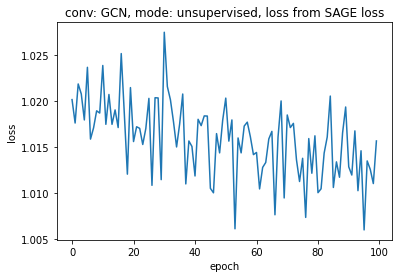

In [16]:
#models = [Net(dataset = dataset,mode='supervised',conv='GCN',device=device), Net(dataset = dataset,mode='supervised',conv='GAT',device=device),Net(dataset = dataset,mode='supervised',conv='SGC',device=device), Net(dataset = dataset,mode='unsupervised',conv='GCN',device=device),Net(dataset = dataset,mode='unsupervised',conv='GAT',device=device),Net(dataset = dataset,mode='unsupervised',conv='SAGE',device=device)]
# lr=0.005
SAGE = {"Name":"SAGE" , "walk length":10,"walks per node":1,"num negative samples":10,"context size" :5 ,"p":1,"q":1, "loss var": "Random Walks"}
DeepWalk = {"Name": "DeepWalk","walk length":10,"walks per node":10,"num negative samples":10,"context size" : 10,"p":1,"q":1,"loss var": "Random Walks" } #Проблемы с памятью после того, как увеличила количество тренировочных данных
#DeepWalk = {"Name": "DeepWalk","walk length":40,"walks per node":80,"num negative samples":20,"context size" : 10,"p":1,"q":1,"loss var": "Random Walks" } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk length":20,"walks per node":10,"num negative samples":1,"context size" : 10,"p":1.414 ,"q":1.414, "loss var": "Random Walks"}#то же самое 
#Node2Vec = {"Name": "Node2Vec","walk length":100,"walks per node":18,"num negative samples":20,"context size" : 16,"p":1.414 ,"q":1.414, "loss var": "Random Walks"}#то же самое 

LINE2 = {"Name": "LINE2","C": "Adj","num negative samples":10,"loss var": "Context Matrix"} #настроить параметры в принципе при 0.003 что то выходит  
HOPE_RPR = {"Name": "HOPE: RPR","C":"RPR","loss var": "Factorization"}#оч большой loss


GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization"} #jоч большой loss
HOPE_Katz = {"Name": "HOPE: Katz","C":"Katz","loss var": "Factorization"}#Проблемы оч большой loss
VERSE_PPR =  {"Name": "VERSE","C": "PPR","num negative samples":10,"loss var": "Context Matrix"}  #проблеиы

sizes = [[5],[10],[25],[5,10],[10,25],[5,10,25]]

hidden_layer = 64
out_layer = 128
dropout = 0.5
size = [10,25]
learning_rate = 0.003

classifier = "logistic regression"

from datetime import datetime
d = datetime.now()
for Conv in ['GCN']:
    for loss in [SAGE]:
        #train_loader = NeighborSampler(data.edge_index, batch_size = 2708, sizes=size)
       
        #LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
        #model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
        #model.to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay = 1e-5)
        #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
       # scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.1)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+loss["Name"]
       
        print(name_of_plot)
        
        for epoch in range(100):
            print(epoch)
            loss = train_lp(model,data,optimizer,LossSampler,train_loader,0)
            losses.append(loss)
            #print(loss)
            
            #train_accs.append(train_acc)
#test_accs.append(test_acc)
        test_acc = test_lp(model,data,'logistic regression',y_true)
           # val_accs.append(val_acc)
           # log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
            #scheduler.step()
            #print(log.format(loss, epoch, train_acc, test_acc))
        print('Test acc on the last epoch ', test_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

In [15]:
test_lp(model,data,'logistic regression',y_true)

tensor(0.5456)
tensor(0.5456)
tensor(0.8777)
tensor(0.5346)
tensor(0.5346)
tensor(0.8731)
tensor(0.8744)
tensor(0.8244)
tensor(0.8530)
tensor(0.6835)
tensor(0.8793)
tensor(0.8783)
tensor(0.5192)
tensor(0.9472)
tensor(0.9849)
tensor(0.8098)
tensor(0.8714)
tensor(0.7824)
tensor(0.5156)
tensor(0.6903)
tensor(0.8281)
tensor(0.6517)
tensor(0.8144)
tensor(0.8643)
tensor(0.7386)
tensor(0.7589)
tensor(0.7512)
tensor(0.7184)
tensor(0.7774)
tensor(0.9215)
tensor(0.9387)
tensor(0.8312)
tensor(0.8565)
tensor(0.8396)
tensor(0.8460)
tensor(0.6598)
tensor(0.8796)
tensor(0.8539)
tensor(0.9292)
tensor(0.8395)
tensor(0.6355)
tensor(0.7475)
tensor(0.6487)
tensor(0.9205)
tensor(0.5879)
tensor(0.8086)
tensor(0.9191)
tensor(0.9355)
tensor(0.7711)
tensor(0.7963)
tensor(0.5014)
tensor(0.8089)
tensor(0.9680)
tensor(0.9661)
tensor(0.9195)
tensor(0.6442)
tensor(0.8722)
tensor(0.8654)
tensor(0.8472)
tensor(0.8180)
tensor(0.7753)
tensor(0.8899)
tensor(0.7746)
tensor(0.7883)
tensor(0.8504)
tensor(0.8570)
tensor(0.8

tensor(0.6096)
tensor(0.9750)
tensor(0.7296)
tensor(0.6719)
tensor(0.9818)
tensor(0.5401)
tensor(0.8148)
tensor(0.8183)
tensor(0.8797)
tensor(0.7846)
tensor(0.8714)
tensor(0.5285)
tensor(0.9116)
tensor(0.7623)
tensor(0.9030)
tensor(0.8725)
tensor(0.9048)
tensor(0.6947)
tensor(0.6245)
tensor(0.6706)
tensor(0.6613)
tensor(0.6128)
tensor(0.5564)
tensor(0.5564)
tensor(0.6093)
tensor(0.4577)
tensor(0.8660)
tensor(0.9282)
tensor(0.8801)
tensor(0.8308)
tensor(0.6226)
tensor(0.6704)
tensor(0.6073)
tensor(0.7163)
tensor(0.9448)
tensor(0.9647)
tensor(0.8486)
tensor(0.9168)
tensor(0.8974)
tensor(0.8403)
tensor(0.9673)
tensor(0.8621)
tensor(0.8735)
tensor(0.9193)
tensor(0.9257)
tensor(0.7371)
tensor(0.8223)
tensor(0.8305)
tensor(0.8399)
tensor(0.8805)
tensor(0.7860)
tensor(0.9499)
tensor(0.9658)
tensor(0.9813)
tensor(0.7786)
tensor(0.8975)
tensor(0.9591)
tensor(0.9698)
tensor(0.9157)
tensor(0.8902)
tensor(0.8687)
tensor(0.6271)
tensor(0.7892)
tensor(0.7582)
tensor(0.7806)
tensor(0.8669)
tensor(0.8

tensor(0.9972)
tensor(0.9937)
tensor(0.9856)
tensor(0.9817)
tensor(0.9978)
tensor(0.9931)
tensor(0.9957)
tensor(0.9999)
tensor(0.9433)
tensor(0.8990)
tensor(0.9991)
tensor(0.9962)
tensor(0.9992)
tensor(0.9761)
tensor(0.7880)
tensor(0.9594)
tensor(0.8136)
tensor(0.7987)
tensor(0.7319)
tensor(0.8013)
tensor(0.7942)
tensor(0.7685)
tensor(0.7946)
tensor(0.7926)
tensor(0.8816)
tensor(0.8871)
tensor(0.7478)
tensor(0.8657)
tensor(0.9628)
tensor(0.7995)
tensor(0.8601)
tensor(0.6951)
tensor(0.5233)
tensor(0.8159)
tensor(0.7478)
tensor(0.7363)
tensor(0.8698)
tensor(0.7395)
tensor(0.8612)
tensor(0.5231)
tensor(0.8493)
tensor(0.8939)
tensor(0.8760)
tensor(0.9972)
tensor(0.7998)
tensor(0.7838)
tensor(0.7235)
tensor(0.6943)
tensor(0.7945)
tensor(0.7628)
tensor(0.8424)
tensor(0.8401)
tensor(0.7125)
tensor(0.5989)
tensor(0.2577)
tensor(0.7169)
tensor(0.9314)
tensor(0.7885)
tensor(0.9327)
tensor(0.8953)
tensor(0.9586)
tensor(0.8064)
tensor(0.8497)
tensor(0.8788)
tensor(0.8450)
tensor(0.9430)
tensor(0.9

tensor(0.8057)
tensor(0.8144)
tensor(0.6640)
tensor(0.7372)
tensor(0.8227)
tensor(0.8477)
tensor(0.8830)
tensor(0.9244)
tensor(0.8480)
tensor(0.6841)
tensor(0.7761)
tensor(0.6813)
tensor(0.7376)
tensor(0.8055)
tensor(0.8955)
tensor(0.9648)
tensor(0.8003)
tensor(0.7160)
tensor(0.6664)
tensor(0.5998)
tensor(0.7211)
tensor(0.4891)
tensor(0.5296)
tensor(0.8468)
tensor(0.8158)
tensor(0.7771)
tensor(0.7528)
tensor(0.9299)
tensor(0.9247)
tensor(0.9097)
tensor(0.9052)
tensor(0.8442)
tensor(0.8114)
tensor(0.9079)
tensor(0.8398)
tensor(0.8338)
tensor(0.7957)
tensor(0.8714)
tensor(0.8981)
tensor(0.6069)
tensor(0.9363)
tensor(0.6951)
tensor(0.9040)
tensor(0.7002)
tensor(0.9215)
tensor(0.8664)
tensor(0.9740)
tensor(0.8060)
tensor(0.5058)
tensor(0.8384)
tensor(0.8414)
tensor(0.9476)
tensor(0.8866)
tensor(0.7041)
tensor(0.8557)
tensor(0.8484)
tensor(0.9210)
tensor(0.9402)
tensor(0.8780)
tensor(0.7153)
tensor(0.8844)
tensor(0.8350)
tensor(0.7709)
tensor(0.7517)
tensor(0.8949)
tensor(0.9227)
tensor(0.7

tensor(0.8329)
tensor(0.9085)
tensor(0.5524)
tensor(0.7996)
tensor(0.6061)
tensor(0.7151)
tensor(0.8873)
tensor(0.7238)
tensor(0.8871)
tensor(0.9932)
tensor(0.7939)
tensor(0.9598)
tensor(0.8409)
tensor(0.8376)
tensor(0.8044)
tensor(0.9846)
tensor(0.8610)
tensor(0.8174)
tensor(0.7959)
tensor(0.8363)
tensor(0.9951)
tensor(0.7958)
tensor(0.8464)
tensor(0.8124)
tensor(0.9079)
tensor(0.8822)
tensor(0.6846)
tensor(0.8804)
tensor(0.7229)
tensor(0.7998)
tensor(0.6957)
tensor(0.8901)
tensor(0.8178)
tensor(0.8621)
tensor(0.9103)
tensor(0.6816)
tensor(0.6752)
tensor(0.9309)
tensor(0.7554)
tensor(0.6858)
tensor(0.5627)
tensor(0.8872)
tensor(0.9427)
tensor(0.8839)
tensor(0.8937)
tensor(0.5915)
tensor(0.7362)
tensor(0.7988)
tensor(0.8178)
tensor(0.7675)
tensor(0.6916)
tensor(0.8477)
tensor(0.9100)
tensor(0.8985)
tensor(0.6001)
tensor(0.8990)
tensor(0.8525)
tensor(0.9046)
tensor(0.6430)
tensor(0.8659)
tensor(0.5195)
tensor(0.8180)
tensor(0.7969)
tensor(0.8102)
tensor(0.6005)
tensor(0.7985)
tensor(0.8

tensor(0.9283)
tensor(0.8096)
tensor(0.8854)
tensor(0.9855)
tensor(0.8511)
tensor(0.8443)
tensor(0.8661)
tensor(0.7914)
tensor(0.9793)
tensor(0.7976)
tensor(0.5192)
tensor(0.4466)
tensor(0.5441)
tensor(0.9339)
tensor(0.9669)
tensor(0.8937)
tensor(0.7683)
tensor(0.9870)
tensor(0.6502)
tensor(0.8303)
tensor(0.9332)
tensor(0.8451)
tensor(0.9933)
tensor(0.5775)
tensor(0.7917)
tensor(0.5455)
tensor(0.7869)
tensor(0.7414)
tensor(0.7368)
tensor(0.8046)
tensor(0.8601)
tensor(0.7902)
tensor(0.6806)
tensor(0.8975)
tensor(0.8800)
tensor(0.8305)
tensor(0.9751)
tensor(0.7197)
tensor(0.6965)
tensor(0.8192)
tensor(0.7376)
tensor(0.8373)
tensor(0.8045)
tensor(0.6697)
tensor(0.6531)
tensor(0.7146)
tensor(0.8205)
tensor(0.6221)
tensor(0.8885)
tensor(0.3944)
tensor(0.7928)
tensor(0.8114)
tensor(0.9257)
tensor(0.6121)
tensor(0.7339)
tensor(0.8992)
tensor(0.5116)
tensor(0.7926)
tensor(0.6898)
tensor(0.7562)
tensor(0.9975)
tensor(0.9030)
tensor(0.7873)
tensor(0.6203)
tensor(0.8275)
tensor(0.8831)
tensor(0.7

tensor(0.8011)
tensor(0.6895)
tensor(0.8620)
tensor(0.9349)
tensor(0.8329)
tensor(0.8278)
tensor(0.6870)
tensor(0.7596)
tensor(0.7719)
tensor(0.8623)
tensor(0.7887)
tensor(0.9435)
tensor(0.8269)
tensor(0.7464)
tensor(0.7938)
tensor(0.7897)
tensor(0.6673)
tensor(0.6422)
tensor(0.6757)
tensor(0.8465)
tensor(0.7794)
tensor(0.7156)
tensor(0.8789)
tensor(0.8578)
tensor(0.8667)
tensor(0.7675)
tensor(0.8222)
tensor(0.7405)
tensor(0.8831)
tensor(0.6516)
tensor(0.8144)
tensor(0.8190)
tensor(0.8174)
tensor(0.8966)
tensor(0.9412)
tensor(0.8830)
tensor(0.9412)
tensor(0.8055)
tensor(0.6841)
tensor(0.8594)
tensor(0.7927)
tensor(0.8819)
tensor(0.7800)
tensor(0.9648)
tensor(0.6800)
tensor(0.8256)
tensor(0.6664)
tensor(0.7838)
tensor(0.4891)
tensor(0.8468)
tensor(0.7771)
tensor(0.9299)
tensor(0.9247)
tensor(0.5892)
tensor(0.9116)
tensor(0.8657)
tensor(0.8457)
tensor(0.9273)
tensor(0.7957)
tensor(0.8981)
tensor(0.9073)
tensor(0.7560)
tensor(0.5278)
tensor(0.9043)
tensor(0.7745)
tensor(0.8060)
tensor(0.8

0.5

In [ ]:
test_acc = test_lp(model,data,'logistic regression',y_true)
print('Test acc on the last epoch ', test_acc)

# optuna

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [5]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,20,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    #classifier = "logistic regression"
    classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [5]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,20,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    classifier = "logistic regression"
    #classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer =32# trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [10]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,20,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    #classifier = "logistic regression"
    classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer =32# trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [10]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,10,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    classifier = "logistic regression"
    #classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [25]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,10,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    #classifier = "logistic regression"
    classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [25]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,10,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    classifier = "logistic regression"
    #classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))